# 3 Model creation and training

In [1]:
# import all libraries
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn

from utils import dataset_treatment

Now that we found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

### Loading

In [15]:
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';') # We load azdias only to facilitate the cleaning
mailout_data = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [20]:
print(mailout_data.RESPONSE.value_counts())

0    42430
1      532
Name: RESPONSE, dtype: int64


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='RESPONSE', ylabel='count'>

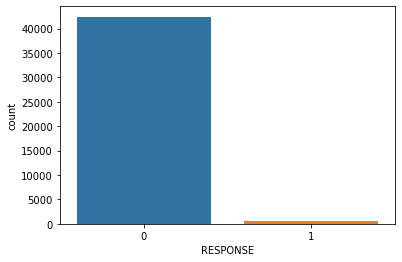

In [17]:
sns.countplot("RESPONSE", data=mailout_data)

As we can see the data is highly imbalanced. 98.7% (42430/(42430+532) X 100) of the training examples are labelled as "0" or "not responsive". This will need to be accounted for.  
First, let's clean our dataset and split the labels from the features.

### Splitting and cleaning

In [21]:
Y = pd.DataFrame(mailout_data["RESPONSE"])
del mailout_data["RESPONSE"]

In [22]:
azidias, X = dataset_treatment(azdias, mailout_data, cust=False)
azidias = None # Clear space

Deleting columns...
Deleting rows...
Encoding...


In [23]:
X.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,-0.934331,-0.380285,-1.320001,0.451529,-0.125303,-0.299061,-0.634469,0.408856,-0.06066,-0.183295,...,-0.355045,-0.356180,-1.698063,-1.764638,0.952074,0.547826,-0.555878,-0.279664,0.958448,1.093087
1,-0.110613,0.276209,-0.212013,-0.474979,-0.125303,-0.299061,0.224688,-0.472535,-0.06066,-1.187413,...,0.510398,-1.757682,-1.698063,-1.764638,-0.181123,0.547826,1.553315,-1.700552,0.958448,0.168026
2,-0.934331,-0.248986,-1.541598,-0.541158,-0.125303,-0.299061,-1.493626,-0.472535,-0.06066,0.820823,...,-1.220488,-0.005804,-1.084069,-1.406915,0.952074,0.547826,-1.083176,-0.279664,-1.043354,1.093087
3,-0.934331,-0.642882,-1.763196,-0.276441,-0.125303,-0.299061,0.224688,-0.252188,-0.06066,0.820823,...,1.375841,0.694947,1.064908,1.812596,0.952074,0.547826,-1.610474,-0.279664,0.958448,1.093087
4,-0.934331,-0.248986,-1.098403,2.966336,-0.125303,-0.299061,-0.634469,2.685783,-0.06066,-0.183295,...,1.375841,-1.407306,-1.698063,-1.764638,0.952074,0.547826,-0.555878,-0.279664,-1.043354,0.168026


In [26]:
Y.head()

0    0
1    0
2    0
3    0
4    0
Name: RESPONSE, dtype: int64

In [ ]:
# Let's split our dataset into 80% training and 20% validation.
X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(X, Y, test_size=0.2)

### Save the data locally 
We will use pandas to save our train and validation data to csv files. Note that we make sure not to include header information or an index as this is required by the built in algorithms provided by Amazon. Also, for the train and validation data, it is assumed that the first entry in each row is the target variable.